In [1]:
# common imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.base import clone

# global variables
BANK_DATA_PATH = r"data/Bank Customer Churn Prediction.csv"
RANDOM_STATE = 42

# Getting the Data

In [2]:
def load_data(path=BANK_DATA_PATH):
    return pd.read_csv(path)

In [3]:
bank = load_data()
bank.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Quick Look at the Data

In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
# all customer id's are unique- so this column can be dropped
bank['customer_id'].nunique()

10000

In [6]:
bank['country'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [7]:
bank['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [8]:
# description of numerical attributes
bank.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


What we know so far:
* Credit score: minimum: 350, maximum: 850
* Age: minimum: 18, maximum: 92
* Balance: minimum: 0 (no negative values!), maximum: 250,898
* Number of products: minimum: 1, maximum: 4. These values make sense- if a customer has an account, they should be using at least one of the facilities/services the bank provides.
* Number of credit cards: minimum: 0, maximum: 1. This also seems reasonable- a customer can have an account but not have a credit card.
* Estimated salary: minimum: 11.58, maximum: 199,992.48.

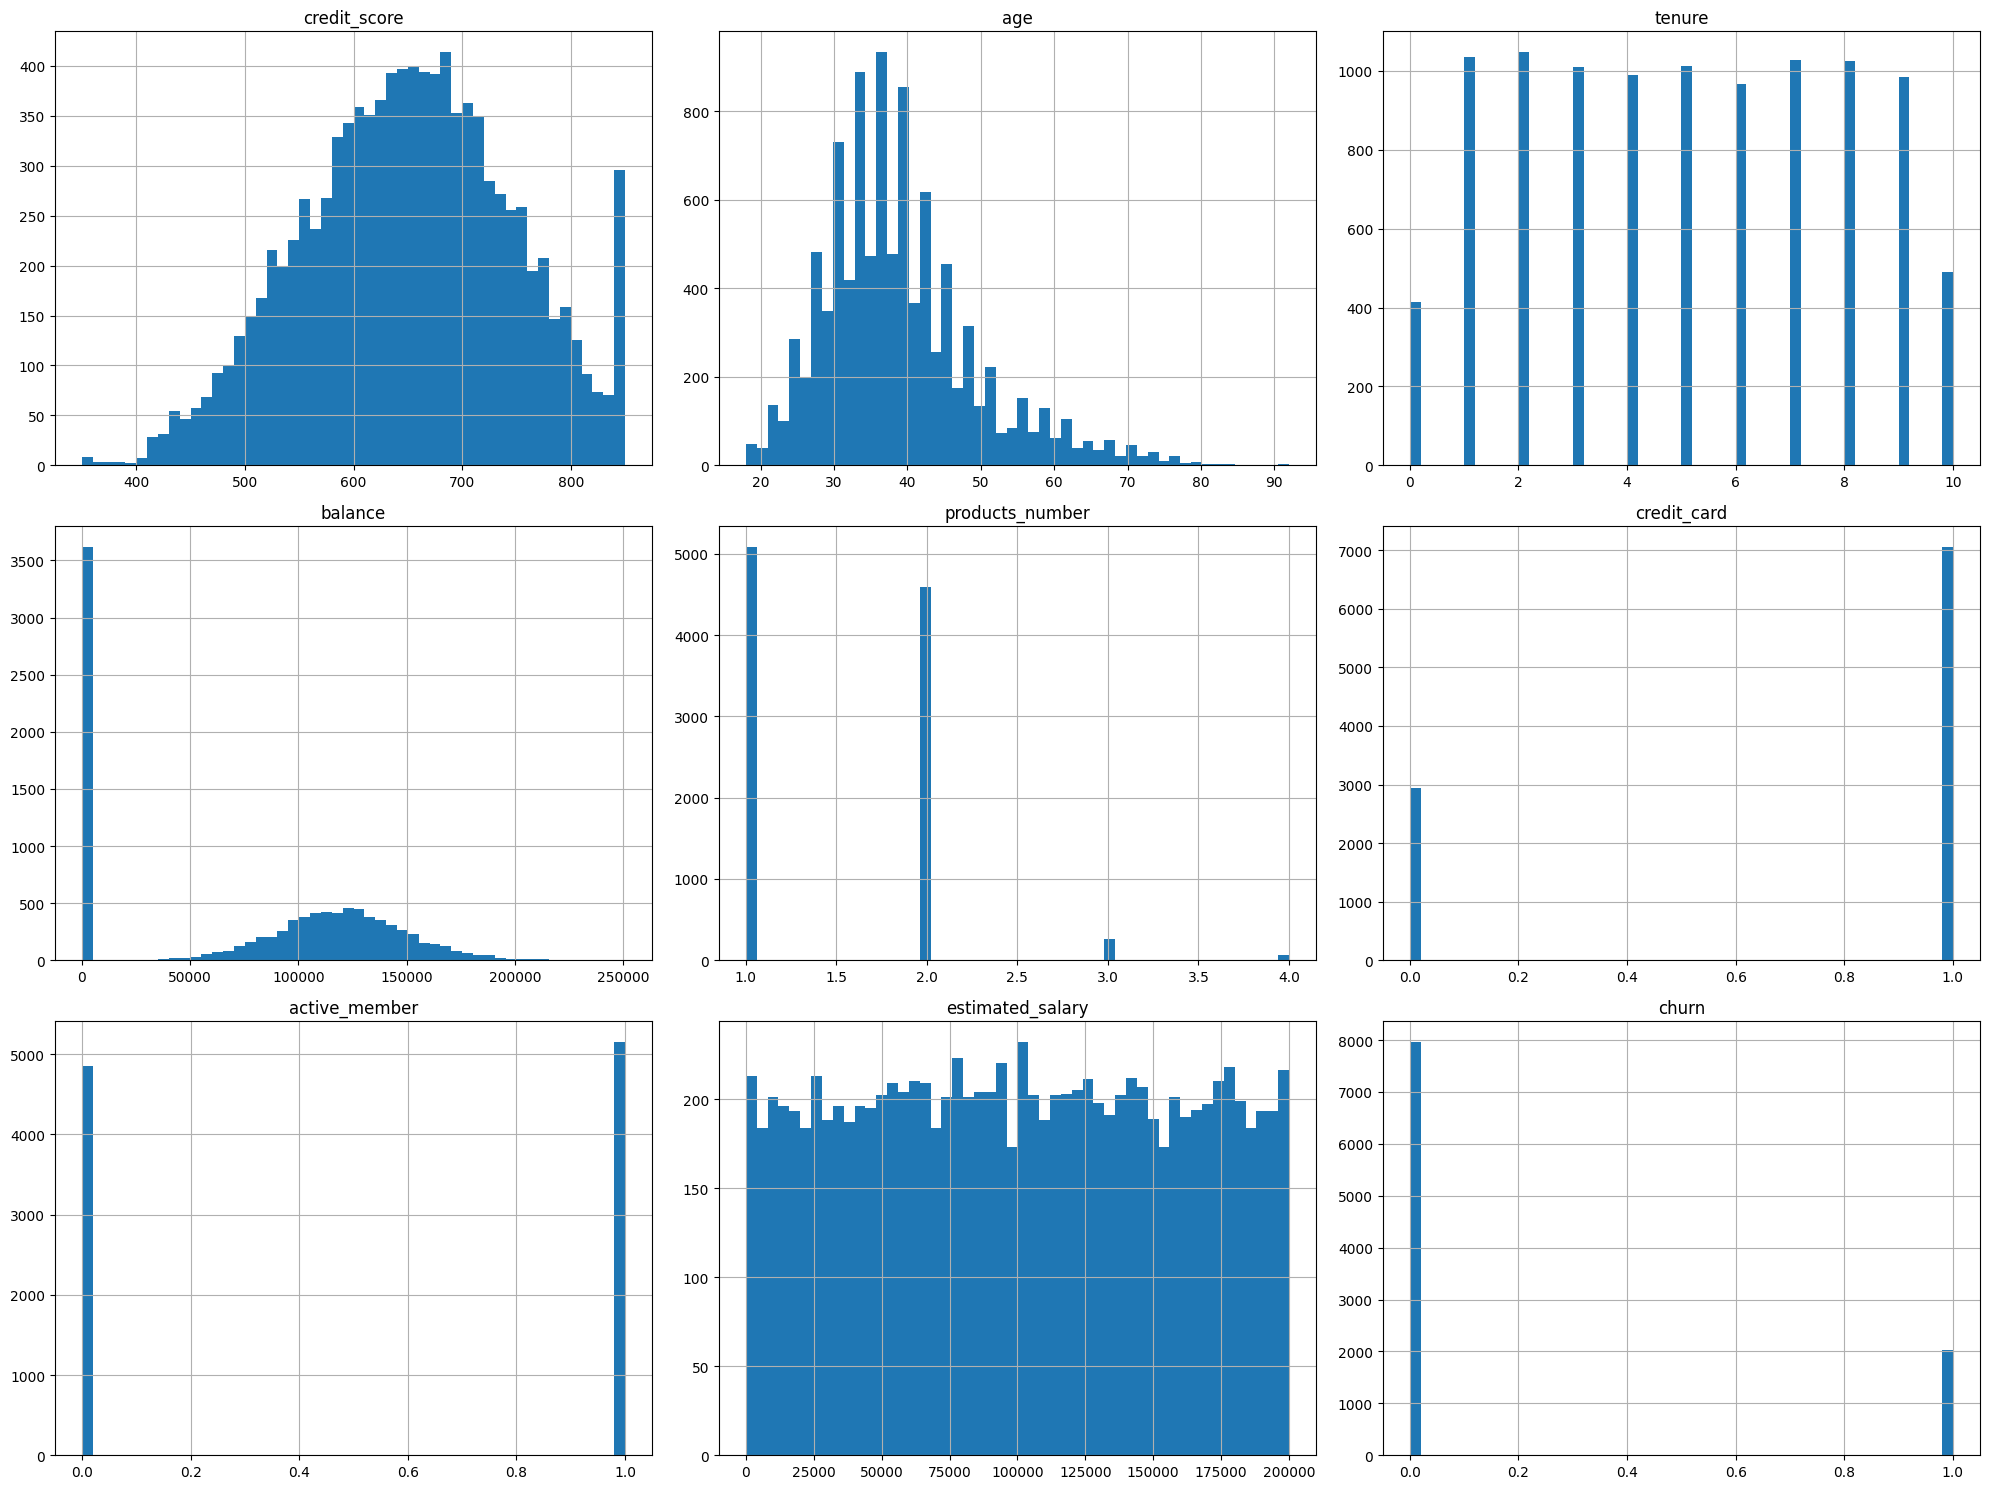

In [9]:
bank[bank.columns[1:]].hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

From the histograms:
* The credit_score, age, and balance columns resemble a bell curve.
* There are around 3500 accounts with 0 balance, which raises the question- are these inactive accounts?
* Most accounts are customers in their 30's-40's.
* Most people have had their account for 1 to 9 years. Few have had an account for less than a year, or 10 or more years.
* Customer's tend to have 1 or 2 products/services the bank provides and rarely have 3 or 4.
* The active_member and estimated salary columns spread nearly uniformly.

### CHALLENGE:
The histogram shows that the churn column is **imbalanced**. If we split the data randomly into a training and test set, there is a risk of sampling bias.
In other words, if we randomly split the data we could get a different distribution of the labels which would misrepresent the actual distribution.
This could affect the results of the trained models, especially since we only have 10,000 samples.
### SOLUTION:
We can use **stratified sampling** to divide the data. This way, the right amount of instances are sampled to guarantee the test set represents the overall population.

# Splitting the Data

In [10]:
def split_train_test_stratified(data, test_ratio=0.2, column_name='churn', random_state=RANDOM_STATE):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_state)
    for train_index, test_index in split.split(data, data[column_name]):
        train = data.loc[train_index]
        test = data.loc[test_index]
        return train.reset_index(), test.reset_index()


train_set, test_set = split_train_test_stratified(data=bank)

In [11]:
train_set.reset_index()

,level_0,index,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,0,2151,15588614,753,France,Male,57,7,0.00,1,1,0,159475.08,1
1,1,8392,15641158,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
2,2,5006,15750014,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
3,3,4117,15663964,561,France,Male,37,5,0.00,2,1,0,83093.25,0
4,4,7182,15573520,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7995,4555,15733261,688,Spain,Female,35,6,0.00,1,1,0,25488.43,1
7996,7996,4644,15714240,712,Spain,Male,74,5,0.00,2,0,0,151425.82,0
7997,7997,8942,15709780,667,France,Female,37,9,71786.90,2,1,1,67734.79,0
7998,7998,2935,15689425,687,Spain,Male,35,8,100988.39,2,1,0,22247.27,0


# Exploratory Data Analysis and Visualization

### 1. Is there a country which has more churn?

In [12]:
churn_by_country = train_set.groupby(["country"]).agg(churn_amount=("churn", 'sum'))
churn_by_country = churn_by_country.reset_index()
churn_by_country

,country,churn_amount
0,France,635
1,Germany,663
2,Spain,332


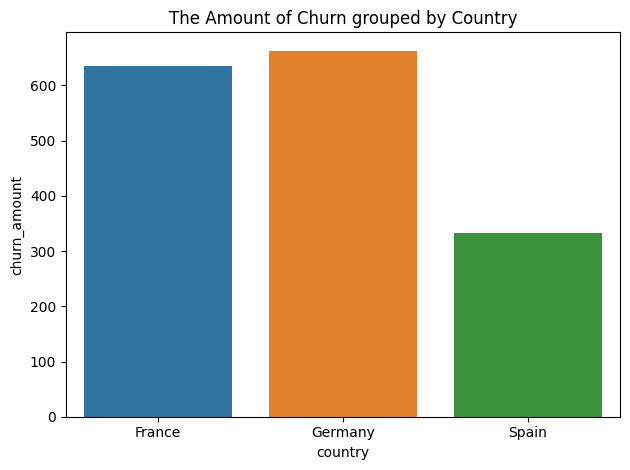

In [13]:
plt.title("The Amount of Churn grouped by Country")
sns.barplot(x="country",
            y="churn_amount",
            data=churn_by_country)
plt.tight_layout()
plt.show()

### 2. What is the correlation between each feature and the label we are trying to predict?

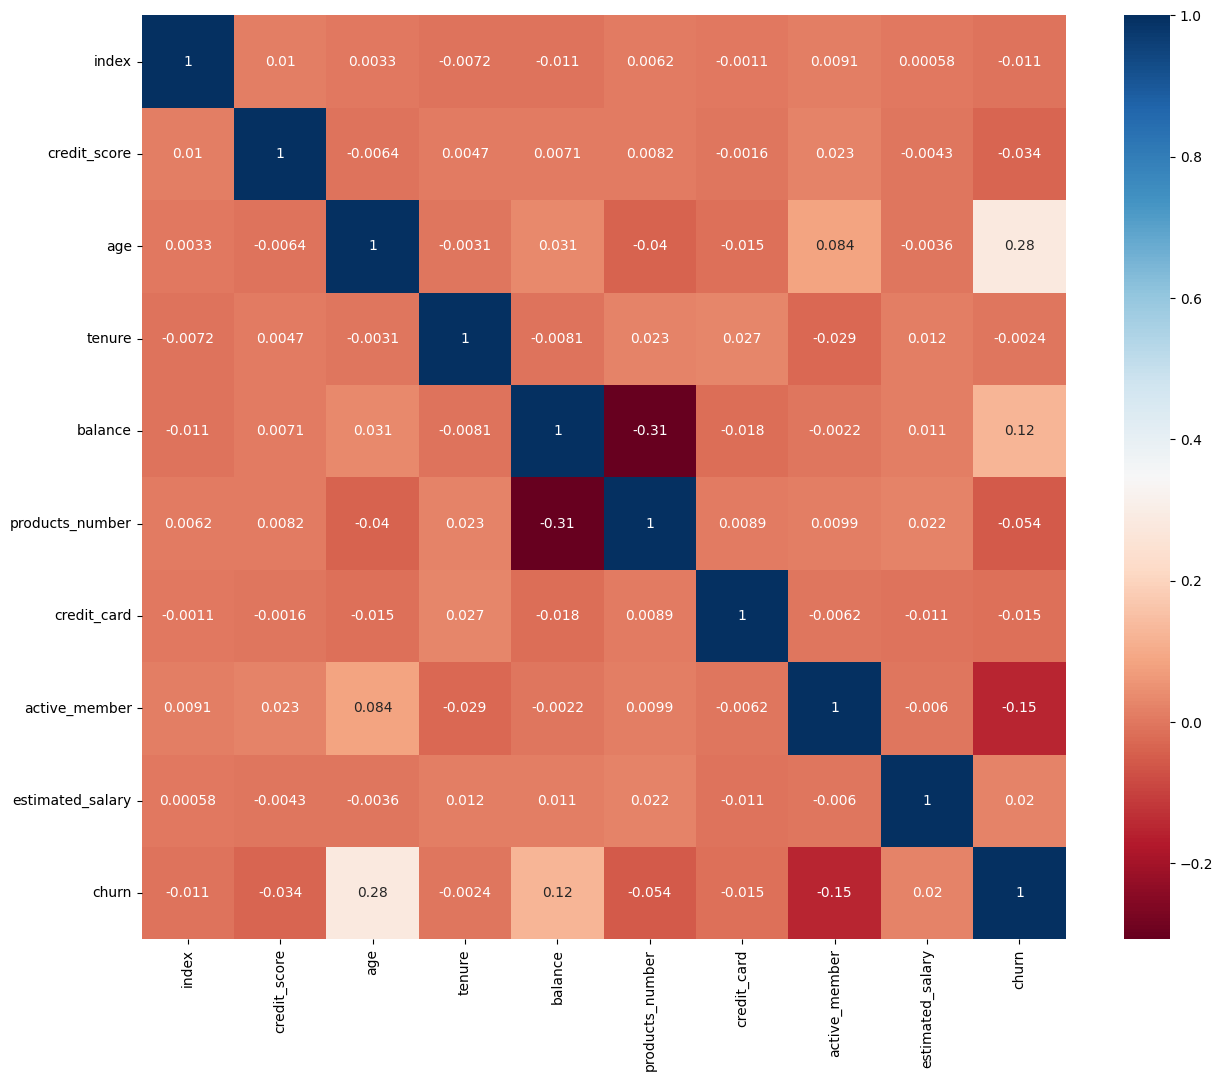

In [14]:
colormap = plt.cm.RdBu

sns.heatmap(train_set.drop(['customer_id'], axis=1).corr(numeric_only=True), annot=True, cmap=colormap, square=True)

fig = plt.gcf()
fig.set_size_inches(15, 12)

plt.show()

### 3. What is the churn according to gender in each country? Are there countries that have more females or males who churn?
In all three countries, women are more likely to churn!

In [15]:
churn_by_country_gender = train_set.groupby(["country", "gender"]).agg(churn_amount=("churn", 'sum'))
churn_by_country_gender = churn_by_country_gender.reset_index()
churn_by_country_gender

,country,gender,churn_amount
0,France,Female,358
1,France,Male,277
2,Germany,Female,361
3,Germany,Male,302
4,Spain,Female,187
5,Spain,Male,145


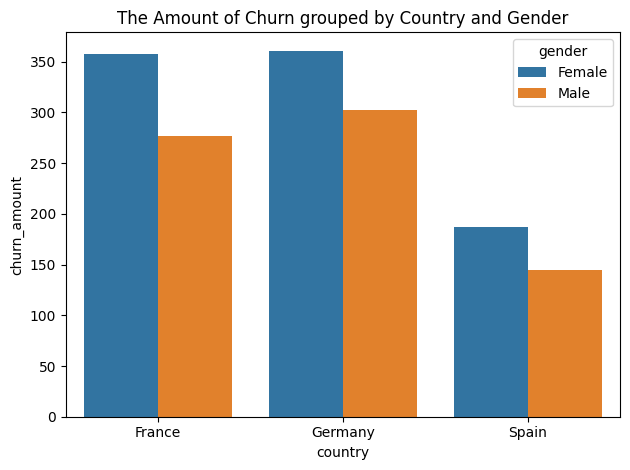

In [16]:
plt.title("The Amount of Churn grouped by Country and Gender")
sns.barplot(x="country",
            y="churn_amount",
            hue="gender",
            data=churn_by_country_gender)
plt.tight_layout()
plt.show()

### 4. What is the credit score according to gender?

In [17]:
avg_credit_score_gender = bank.groupby(["gender"]).agg(mean_credit_score=("credit_score", 'mean'))
avg_credit_score_gender = avg_credit_score_gender.reset_index()
avg_credit_score_gender

,gender,mean_credit_score
0,Female,650.831389
1,Male,650.276892


In [18]:
avg_credit_score_country_gender = bank.groupby(["country", "gender"]).agg(mean_credit_score=("credit_score", 'mean'))
avg_credit_score_country_gender = avg_credit_score_country_gender.reset_index()
avg_credit_score_country_gender

,country,gender,mean_credit_score
0,France,Female,649.185759
1,France,Male,650.064657
2,Germany,Female,653.093881
3,Germany,Male,649.966565
4,Spain,Female,651.769513
5,Spain,Male,650.992075


### 5. Are there countries who have long/short term clients? (tenure feature)


In [19]:
avg_tenure_per_country_gender = train_set.groupby(["country", "gender"]).agg(mean_tenure=("tenure", 'mean'))
avg_tenure_per_country_gender = avg_tenure_per_country_gender.reset_index()
avg_tenure_per_country_gender

,country,gender,mean_tenure
0,France,Female,4.954010
1,France,Male,5.031222
2,Germany,Female,5.023158
3,Germany,Male,5.043602
4,Spain,Female,4.990909
5,Spain,Male,5.076649


### 6. What is the average credit score per country? per gender?

In [20]:
avg_credit_score_country_gender = train_set.groupby(["country", "gender"]).agg(mean_age=("credit_score", 'mean'))
avg_credit_score_country_gender = avg_credit_score_country_gender.reset_index()

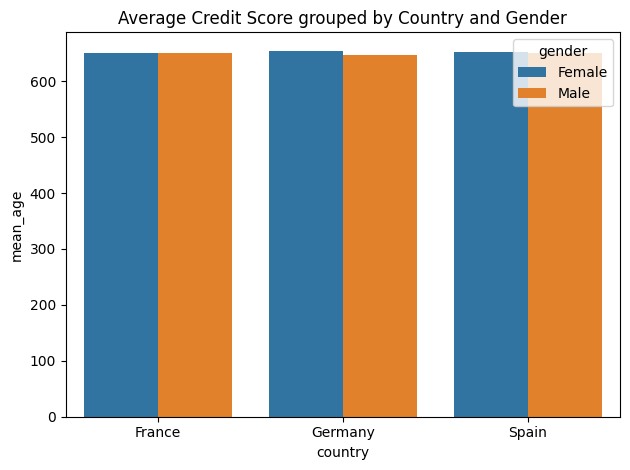

In [21]:
plt.title("Average Credit Score grouped by Country and Gender")
sns.barplot(x="country",
            y="mean_age",
            hue="gender",
            data=avg_credit_score_country_gender)
plt.tight_layout()
plt.show()

### 7. Which country has the largest average balance?

In [22]:
mean_balance_per_country = train_set.groupby(["country"]).agg(mean_balance=("balance", 'mean'))
mean_balance_per_country = mean_balance_per_country.reset_index()
mean_balance_per_country

,country,mean_balance
0,France,61798.896524
1,Germany,119481.504459
2,Spain,62300.824041


In [23]:
mean_balance_per_country_gender = train_set.groupby(["country", "gender", "churn"]).agg(
    mean_balance=("balance", 'mean'))
mean_balance_per_country_gender = mean_balance_per_country_gender.reset_index()
mean_balance_per_country_gender

,country,gender,churn,mean_balance
0,France,Female,0,58254.589796
1,France,Female,1,68644.868380
2,France,Male,0,61126.574025
3,France,Male,1,75876.075415
4,Germany,Female,0,118668.865789
5,Germany,Female,1,119318.446260
6,Germany,Male,0,119565.761222
7,Germany,Male,1,121051.248974
8,Spain,Female,0,57642.180909
9,Spain,Female,1,72552.962193


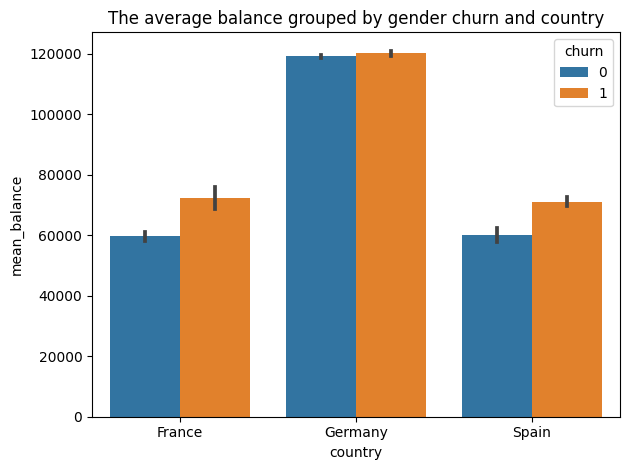

In [24]:
plt.title("The average balance grouped by gender churn and country")
sns.barplot(x="country",
            y="mean_balance",
            hue="churn",
            data=mean_balance_per_country_gender)
plt.tight_layout()
plt.show()

### 9. Is churn related to income?

In [25]:
churned_mean_income = train_set.groupby(["country", "churn"]).agg(mean_estimated_income=("estimated_salary", 'mean'))
churned_mean_income = churned_mean_income.reset_index()
churned_mean_income

,country,churn,mean_estimated_income
0,France,0,98912.496849
1,France,1,104225.744756
2,Germany,0,101542.146207
3,Germany,1,100144.704284
4,Spain,0,97679.519138
5,Spain,1,101580.374096


### 10. Are clients that have more products less likely to churn?

- This is something we can remove

In [26]:
churned_mean_products = train_set.groupby(["churn"]).agg(mean_products=("products_number", 'mean'))
churned_mean_products = churned_mean_products.reset_index()
churned_mean_products

,churn,mean_products
0,0,1.545526
1,1,1.466871


### 11. Are older people that have a higher tenure more likely to stay?

In [27]:
mean_tenure = train_set['tenure'].mean()
mean_age = train_set['age'].mean()
print(f"The average tenure is {mean_tenure}")
print(f"The average age is {mean_age}")

The average tenure is 5.016625
The average age is 38.946625


In [28]:
filtered_df = train_set[(train_set['tenure'] > mean_tenure) & (train_set['age'] > mean_age)]
filtered_df['churn'].value_counts()

0    1054
1     535
Name: churn, dtype: int64

In [29]:
filtered_df_below_avg = train_set[(train_set['tenure'] < mean_tenure) & (train_set['age'] < mean_age)]
filtered_df_below_avg['churn'].value_counts()

0    2212
1     237
Name: churn, dtype: int64

we can see that older people with higher tenure tend to leave compared to younger people with less than average tenure

### What is the average age that people churn?
The mean age of the people that churned

In [30]:
churned_customers = train_set[train_set["churn"] == 1]
churned_mean_age_per_country = churned_customers.groupby(["country", "gender"]).agg(mean_age=("age", 'mean'))
churned_mean_age_per_country = churned_mean_age_per_country.reset_index()
churned_mean_age_per_country

,country,gender,mean_age
0,France,Female,45.343575
1,France,Male,44.851986
2,Germany,Female,44.778393
3,Germany,Male,44.771523
4,Spain,Female,43.518717
5,Spain,Male,44.910345


### What is the percentage of people who churned according to each country?

In [31]:
churn_percentage = churned_customers["country"].value_counts() / train_set['country'].value_counts()

In [32]:
churn_percentage_df = pd.DataFrame({'Country': churn_percentage.index, 'churn percentage': churn_percentage.values})
churn_percentage_df

,Country,churn percentage
0,France,0.159028
1,Germany,0.330673
2,Spain,0.165834


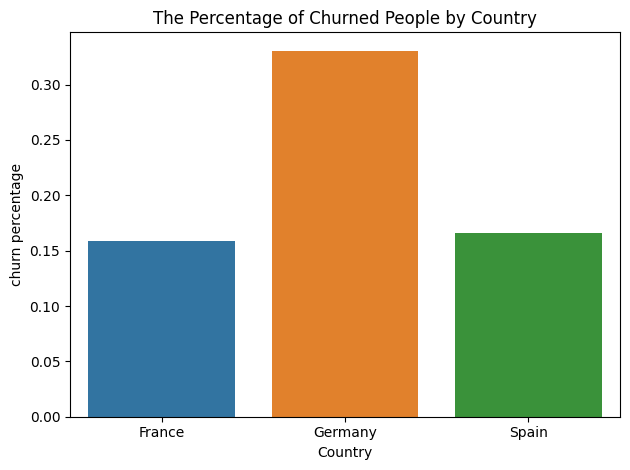

In [33]:
plt.title("The Percentage of Churned People by Country")
sns.barplot(x="Country",
            y="churn percentage",
            data=churn_percentage_df)
plt.tight_layout()
plt.show()

# Conclusion from the data visualization

we saw that germany had the largest percentage of churn with respect to the given amount of data sampled from germany, that also correlates with the fact that the average balance of people in germany is twice as much as the other countries 



More questions:

8 Are the features with small variance affecting the final result of the model?

12 Which one of the models will be the best?

# Data Cleaning
Our goal: Prepare the data for Machine Learning Algorithms.

In [34]:
# train_set_reduced is a temporary set
# after choosing the most promising model, we will train on the train_set as a whole
train_set_reduced, val_set = split_train_test_stratified(data=train_set, test_ratio=0.1)

In [35]:
X_train = train_set_reduced.drop('churn', axis=1)  # drop creates a copy of the data
y_train = train_set_reduced['churn'].copy()

X_val = val_set.drop('churn', axis=1)
y_val = val_set['churn'].copy()

### CHALLENGE:
Some columns are **categorical features** and contain string values.
Although some models can handle categorical features (such as Decision Trees), there are models like SVM which require features to be numerical.
These features need to be transformed to numerical values.
### SOLUTION:
There are 2 techniques we could use:
#### 1. Encode with numbers, one per category.

Pros: Dimensionality will remain the same since no new feature columns are added.

Cons: Could cause some algorithms to learn that nearby values are more similar than distant ones (which is not always true).

#### 2. One-hot encoding: Create one binary attribute per category.

Pros: Solves the problem of the previous methods, in which unrelated columns could be affected by their assigned discrete values.

Cons: Increases dimensionality of the data, which increases the complexity and computational time required.
Could be costly especially when there are many categories.

In [36]:
MULTI_CAT_FEATURES = ['country']
BIN_CAT_FEATURES = ['gender', 'active_member', 'credit_card']
NUMERICAL_FEATURES = ['age', 'tenure', 'balance', 'products_number', 'credit_score', 'estimated_salary']

In [37]:
# by default, columns that are not listed will be dropped
# NOTE: The column customer_id is not listed, so it will be dropped.
pipeline = ColumnTransformer([
    ("num", StandardScaler(), NUMERICAL_FEATURES),
    ("one-hot", OneHotEncoder(), MULTI_CAT_FEATURES),
    ("binary-cat", OrdinalEncoder(), BIN_CAT_FEATURES)
])

In [38]:
X_train_prepared = pipeline.fit_transform(X_train, y_train)
X_val_prepared = pipeline.transform(X_val)

In [39]:
X_train_prepared

array([[-1.01332846e-03,  1.36755658e+00,  6.47595577e-01, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-6.64282868e-01,  1.36755658e+00,  1.49699472e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-9.57661199e-02, -6.98628997e-01,  1.43882798e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       ...,
       [-1.23279962e+00, -3.54264735e-01,  3.28771869e-01, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 7.57009003e-01, -1.04299326e+00,  6.63286849e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-3.80024494e-01, -1.38735752e+00,  4.49576870e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [40]:
X_train_prepared.shape

(7200, 12)

# Model Training

### CHALLENGE:
Accuracy is less relevant for an imbalanced classification problem. Evaluating by a metric that represents the data better is important.

### SOLUTION:
Chosen evaluation metric:

The F1 Score is calculated by using precision (the accuracy of the positive predictions) and recall (the ratio of positive instances correctly classified) accuracy. This metric gives a higher value towards false positives rather than false negatives.

In [41]:
def display_evaluation(classifier_model, X, y, pred):
    # Print scores
    print("Classification Report:\n", classification_report(y, pred, zero_division=1))

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier_model,
        X,
        y,
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

## Baseline Model (Dummy Classifier)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       637
           1       1.00      0.00      0.00       163

    accuracy                           0.80       800
   macro avg       0.90      0.50      0.44       800
weighted avg       0.84      0.80      0.71       800



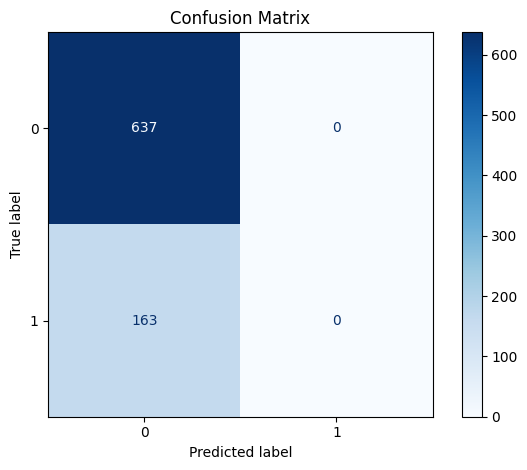

In [42]:
baseline = DummyClassifier()
baseline.fit(X_train_prepared, y_train)
baseline_pred = baseline.predict(X_val_prepared)
display_evaluation(baseline, X_val_prepared, y_val, baseline_pred)

## 1. Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90       637
           1       0.70      0.24      0.36       163

    accuracy                           0.82       800
   macro avg       0.76      0.61      0.63       800
weighted avg       0.81      0.82      0.79       800



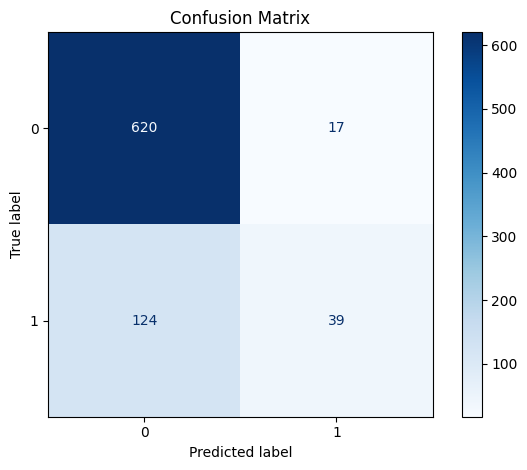

In [43]:
logistic = LogisticRegression(penalty='l2', random_state=RANDOM_STATE)
logistic.fit(X_train_prepared, y_train)
logistic_pred = logistic.predict(X_val_prepared)
display_evaluation(logistic, X_val_prepared, y_val, logistic_pred)

## 2. KNN

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       637
           1       0.71      0.41      0.52       163

    accuracy                           0.85       800
   macro avg       0.79      0.68      0.71       800
weighted avg       0.83      0.85      0.83       800



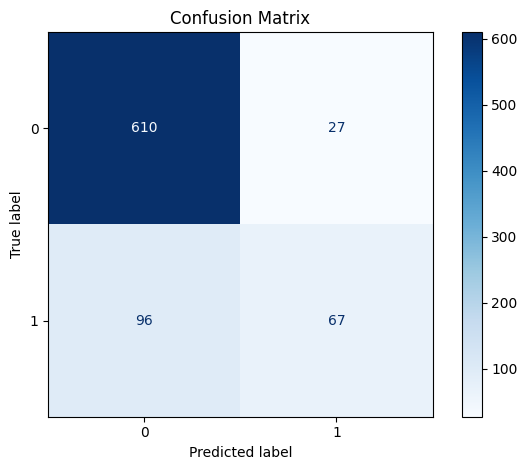

In [44]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train_prepared, y_train)
knn_pred = knn.predict(X_val_prepared)
display_evaluation(knn, X_val_prepared, y_val, knn_pred)

## 3. SVM

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       637
           1       0.91      0.42      0.57       163

    accuracy                           0.87       800
   macro avg       0.89      0.70      0.75       800
weighted avg       0.88      0.87      0.85       800



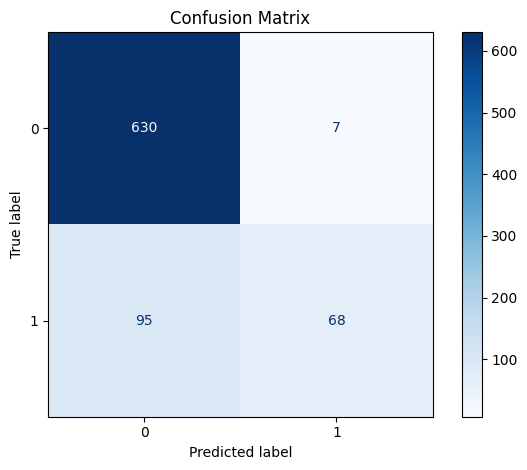

In [45]:
svm = SVC(kernel='rbf', degree=3, coef0=0.0, C=1, random_state=RANDOM_STATE)
svm.fit(X_train_prepared, y_train)
svm_pred = svm.predict(X_val_prepared)
display_evaluation(svm, X_val_prepared, y_val, svm_pred)

## 4. Decision Tree

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       637
           1       0.54      0.58      0.56       163

    accuracy                           0.81       800
   macro avg       0.71      0.73      0.72       800
weighted avg       0.82      0.81      0.82       800



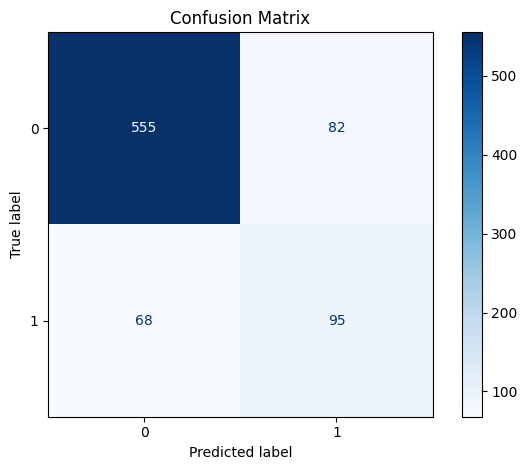

In [46]:
tree = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=RANDOM_STATE)
tree.fit(X_train_prepared, y_train)
tree_pred = tree.predict(X_val_prepared)
display_evaluation(tree, X_val_prepared, y_val, tree_pred)

## 5. AdaBoost

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       637
           1       0.53      0.57      0.55       163

    accuracy                           0.81       800
   macro avg       0.71      0.72      0.71       800
weighted avg       0.81      0.81      0.81       800



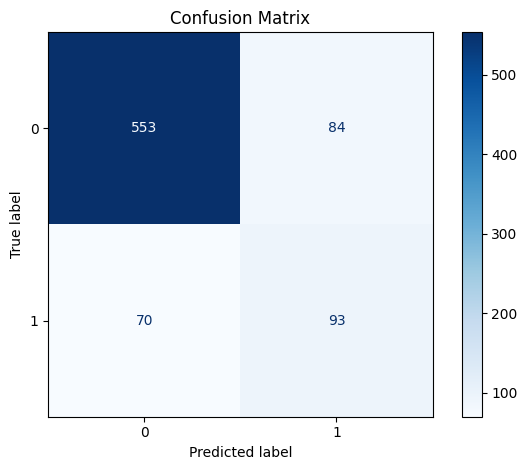

In [47]:
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=RANDOM_STATE)
adaboost.fit(X_train_prepared, y_train)
adaboost_pred = adaboost.predict(X_val_prepared)
display_evaluation(adaboost, X_val_prepared, y_val, adaboost_pred)

## 6. Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       637
           1       0.82      0.46      0.59       163

    accuracy                           0.87       800
   macro avg       0.85      0.72      0.76       800
weighted avg       0.87      0.87      0.86       800



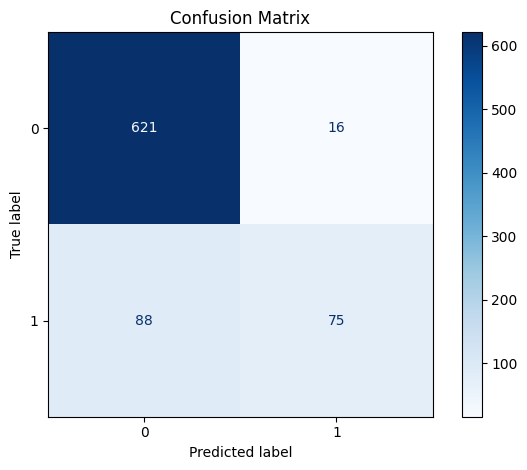

In [48]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=RANDOM_STATE)
forest.fit(X_train_prepared, y_train)
forest_pred = forest.predict(X_val_prepared)
display_evaluation(forest, X_val_prepared, y_val, forest_pred)

# Cross Validation and Hyperparameter Tuning
The most promising models so far are: KNN, SVM, Random Forest.
We will focus on these and tune parameters to try to improve our results.

In [49]:
X_train = train_set.drop('churn', axis=1)  # drop creates a copy of the data
y_train = train_set['churn'].copy()

X_train_prepared = pipeline.fit_transform(X_train, y_train)

## 1. KNN Grid Search

In [50]:
knn_param_grid = [
    {
        'n_neighbors': [3, 5, 9, 13],
        'weights': ['uniform', 'distance'],
        'metric': ['l1', 'l2'],
    }
]

In [51]:
knn_grid_cv = GridSearchCV(clone(knn),
                           knn_param_grid,
                           scoring='f1_weighted',
                           cv=5,
                           verbose=1)
knn_grid_cv.fit(X_train_prepared, y_train)
print(f"Best Params: {knn_grid_cv.best_params_}")
print(f"Best Score: {knn_grid_cv.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'metric': 'l2', 'n_neighbors': 9, 'weights': 'distance'}
Best Score: 0.8258421702297982


## 2. SVM Grid Search

In [52]:
svm_param_grid = [
    {

    }
]

In [53]:
svm_grid_cv = GridSearchCV(clone(svm),
                           svm_param_grid,
                           scoring='f1_weighted',
                           cv=5,
                           verbose=1)
svm_grid_cv.fit(X_train_prepared, y_train)
print(f"Best Params: {svm_grid_cv.best_params_}")
print(f"Best Score: {svm_grid_cv.best_score_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Params: {}
Best Score: 0.8350073091470964


## 3. Random Forest Grid Search

In [54]:
forest_param_grid = [
    {
        'n_estimators': [100, 200, 400],
        # max features that are evaluated before splitting a node
        "max_features": ['log2', 'sqrt', None],
        "bootstrap": [True, False],  # sampling with or without replacement
    }
]

In [55]:
forest_grid_cv = GridSearchCV(clone(forest),
                              forest_param_grid,
                              scoring='f1_weighted',
                              cv=5,
                              verbose=2)
forest_grid_cv.fit(X_train_prepared, y_train)
print(f"Best Params: {forest_grid_cv.best_params_}")
print(f"Best Score: {forest_grid_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END bootstrap=True, max_features=log2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_features=log2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_features=log2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_features=log2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_features=log2, n_estimators=400; total time=   3.3s
[CV] END bootstrap=True, max_features=log2, n_es

# Testing the Final Model

In [56]:
# REMOVE THESE WHEN NEEDED
# X_test = test_set.drop('churn', axis=1)
# y_test = test_set['churn'].copy()